# Camo Worms Genetic Algorithm

In [15]:
# Imports

import numpy as np
import imageio.v3 as iio
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

import cv2 # for cost function 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images

In [16]:
# Global variables

pop_size = 6
epochs = 3

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


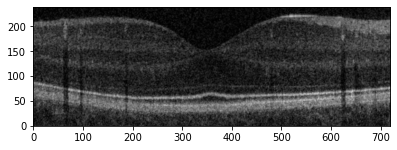

In [17]:
def crop(image, mask):
    h, w = image.shape[:2]  # Adjusted to handle potential color images
    return image[max(mask[0], 0):min(mask[1], h), max(mask[2], 0):min(mask[3], w)]

def prep_image(imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    filepath = os.path.join(imdir, imname + ".png")
    image = np.flipud(crop(iio.imread(filepath), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image), 1), round(np.std(image), 1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')  # Use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [134]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.bezier as mbezier

class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.deviation_r = deviation_r
        self.deviation_gamma = deviation_gamma
        self.width = width
        self.colour = colour
        # calc the bezier control points
        p0 = np.array([self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)])
        p2 = np.array([self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)])
        p1 = np.array([self.x + self.deviation_r * np.cos(self.theta + self.deviation_gamma),
                       self.y + self.deviation_r * np.sin(self.theta + self.deviation_gamma)])
        self.control_points = [p0, p1, p2]

    def patch(self):
        # Create a path with MOVETO, CURVE3, CURVE3 which corresponds to a quadratic Bezier curve
        codes = [mpath.Path.MOVETO, mpath.Path.CURVE3, mpath.Path.CURVE3]
        path = mpath.Path(self.control_points, codes)
        return mpatches.PathPatch(path, facecolor='none', edgecolor=self.colour, linewidth=self.width, capstyle='round')

class Drawing:
    def __init__(self, image):
        self.image = image

    def add_worms(self, worms, display=False):
        fig, ax = plt.subplots(figsize=(self.image.shape[1] / 100, self.image.shape[0] / 100), dpi=100)
        ax.imshow(self.image, cmap='gray', origin='lower')
        for worm in worms:
            ax.add_patch(worm.patch())
        ax.set_xlim([0, self.image.shape[1]])
        ax.set_ylim([0, self.image.shape[0]])
        ax.axis('off')
        if display: 
            plt.show()
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return data

class Instance:
    def __init__(self, image):
        self.rng = np.random.default_rng()
        self.image = image  # The environmental image
        self.drawing = Drawing(image)
        self.clew = self._initialise_clew(40, image.shape, (40, 30, 1))  # Initialize worms
        self.image_worm = self.drawing.add_worms(self.clew)  # This now returns an image with worms

    
    def calculate_size_penalty(self):
        # Define ideal sizes (these could be hyperparams)
        ideal_length = 50  # Example ideal length, adjust as needed
        ideal_width = 5    # Example ideal width, adjust as needed
    
        # Initialize penalty
        penalty = 0
    
        try:
            # Calculate penalty for each worm based on deviation from ideal sizes
            for worm in self.clew:
                length_penalty = (worm.r - ideal_length) ** 2  # Assuming 'r' represents the length
                width_penalty = (worm.width - ideal_width) ** 2
                penalty += length_penalty + width_penalty
    
        except Exception as e:
            print(f"Error calculating size penalty: {e}")
            return 0  # Return a default value if an error occurs
    
        return penalty  # Ensure a numeric value is always returned

    # calculate overlap penalty

    def calculate_cost(self):
        # change images to LAB to compute color euclidian distances
        worm_lab = cv2.cvtColor(self.image_worm, cv2.COLOR_RGB2LAB)
        env_lab = cv2.cvtColor(self.image, cv2.COLOR_RGB2LAB)
        worm_mean_lab = np.mean(worm_lab.reshape(-1, 3), axis=0)
        env_mean_lab = np.mean(env_lab.reshape(-1, 3), axis=0)
        color_distance = np.linalg.norm(worm_mean_lab - env_mean_lab)

        # use Canny for edge detection by converting to greyscale (algo does better in greyscale) 
        worm_edges = cv2.Canny(cv2.cvtColor(self.image_worm, cv2.COLOR_RGB2GRAY), 100, 200)
        env_edges = cv2.Canny(cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY), 100, 200)

        # calc edge alignment (NOTE: CAN TRY DIFFERENT METHODS)
        # method below is the Intersection over Union (IoU) method for edge alignment similarity
        edge_alignment = np.sum(worm_edges & env_edges) / np.sum(worm_edges | env_edges) 

        size_penalty = self.calculate_size_penalty()

        # Combine color distance and edge alignment into a single cost metric
        # Note: look to assign weights based on whether edge alignment or colour is more important
        # Note: look into normalising/standardising values
        self.cost = color_distance + (1 - edge_alignment) * 100  + size_penalty
        return self.cost

    def _initialise_clew(self, size, imshape, init_params):
        clew = []
        for _ in range(size):
            midx = imshape[1] * self.rng.random()
            midy = imshape[0] * self.rng.random()
            r = init_params[0] * np.abs(self.rng.standard_normal())
            theta = self.rng.random() * 2 * np.pi
            dr = init_params[1] * np.abs(self.rng.standard_normal())
            dgamma = self.rng.random() * 2 * np.pi
            colour = (self.rng.random(), self.rng.random(), self.rng.random())
            width = init_params[2] * self.rng.standard_gamma(3)
            clew.append(Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour))
        return clew

In [160]:
import random

# mutation rate and mutation intensity are hyperparams

class Genetic_Algorithm:
    def __init__(self, mutation_rate=0.5, mutation_intensity=0.05, position_change_probability=0.7, selection_method='tournament'):
        self.mutation_rate = mutation_rate  # Default mutation rate is set to 10%
        self.mutation_intensity = mutation_intensity  # default is 0.05
        self.position_change_probability = position_change_probability  # Probability to change position d 10%
        self.selection_method = selection_method # which selection method to apply
    
    def select_method(self, population):
        if self.selection_method == 'tournament':
            return self.tournament_select(population)
        elif self.selection_method == 'roulette_wheel':
            return self.roulette_wheel_selection(population)

    # tourney sizes of 2-5% of population are pretty g
    # smaller tourney size = larger diversity
    # Note: could be adaptive tour size: start large, then decrease w/ time 
    def tournament_select(self, population, tournament_size=5): # tournament size could be a hyperparam
        # Select k individuals from the population at random
        tournament = random.sample(population, tournament_size)
        # print(f"Tournament individuals: {[ind.cost for ind in tournament]}")  # Print costs of selected individuals
        
        # Select the individual with the lowest cost
        best_individual = min(tournament, key=lambda x: x.cost)
        # print(f"Selected for crossover: {best_individual.cost}")  # Print cost of selected best individual
        return best_individual

    def roulette_wheel_selection(self, population):
        total_fitness = sum(individual.cost for individual in population)
        selection_probs = [individual.cost / total_fitness for individual in population]
        return random.choices(population, weights=selection_probs, k=1)[0]

    def crossover(self, parent_1, parent_2):
        midpoint = len(parent_1.clew) // 2
        new_clew = parent_1.clew[:midpoint] + parent_2.clew[midpoint:]
        
        # Create a new instance with the combined clew and pass the image from parents
        child = Instance(parent_1.image)  # Assuming both parents have the same environment image
        child.clew = new_clew
        child.image_worm = child.drawing.add_worms(child.clew)
        child.calculate_cost()
        
        return child

    # # multi point crossover
    # def crossover(self, parent_1, parent_2, points=3):
    #     segments = np.linspace(0, len(parent_1.clew), points + 1, dtype=int)
    #     new_clew = []
    #     for i in range(points):
    #         new_clew += parent_1.clew[segments[i]:segments[i+1]] if i % 2 == 0 else parent_2.clew[segments[i]:segments[i+1]]
    #     child = Instance(parent_1.image)
    #     child.clew = new_clew
    #     child.image_worm = child.drawing.add_worms(child.clew)
    #     child.calculate_cost()
    #     return child

    def mutation(self, instance):
        # Implement mutation logic: modify color slightly
        mutation_intensity = self.mutation_intensity  # default is 0.05
        # self.mutation_rate = 1
        # self.position_change_probability = 1
        for worm in instance.clew:
            if random.random() < self.mutation_rate:
                # change = (random.random() - 0.5) * 2
                mutated_color = tuple(min(max(c + random.uniform(-0.5, 0.5), 0), 1) for c in worm.colour)
                worm.colour = mutated_color

             # Mutate Position and Orientation
            if random.random() < self.position_change_probability:
                worm.x += random.uniform(-1, 1) * worm.r * 0.5  # Example positional mutation
                worm.x = min(max(worm.x, 0), 720)
                worm.y += random.uniform(-1, 1) * worm.r * 0.5
                worm.y = min(max(worm.y, 0), 240)
                worm.theta += random.uniform(-0.1, 0.1) * np.pi  # Small rotation
                if worm.theta < 0:
                    worm.theta += np.pi
                if worm.theta > np.pi:
                    worm.theta -= np.pi

             # Mutate Size and Shape
            if random.random() < self.mutation_rate:
                worm.r += random.uniform(-1, 1) * worm.r * 0.1  # Example size mutation
                worm.deviation_r = random.uniform(0.8, 1.25) * worm.deviation_r   # Example shape mutation
                worm.deviation_gamma += random.uniform(-0.5, 0.5) * np.pi * 0.5
                if worm.deviation_gamma < 0:
                    worm.deviation_gamma += np.pi
                if worm.deviation_gamma > np.pi:
                    worm.deviation_gamma -= np.pi
                worm.width = random.uniform(0.9, 1.1) * worm.width

            # update position
            worm.p0 = np.array([worm.x - worm.r * np.cos(worm.theta), worm.y - worm.r * np.sin(worm.theta)])
            worm.p2 = np.array([worm.x + worm.r * np.cos(worm.theta), worm.y + worm.r * np.sin(worm.theta)])
            worm.p1 = np.array([worm.x + worm.deviation_r * np.cos(worm.theta + worm.deviation_gamma),
                        worm.y + worm.deviation_r * np.sin(worm.theta + worm.deviation_gamma)])
            worm.control_points = [worm.p0, worm.p1, worm.p2]
        instance.image_worm = instance.drawing.add_worms(instance.clew)  # redraw the worms
        instance.calculate_cost()  # Recalculate cost
        return instance
        
    def run_genetic_algorithm(self, population, epochs, display_interval=1):
        for epoch in range(epochs):
            new_pop = []
            while len(new_pop) < len(population):
                parent_1 = self.select_method(population)
                parent_2 = self.select_method(population)
                # ensure parents are not identical
                # while parent_1 == parent_2:
                #     parent_2 = self.select_method(population)
                
                child = self.crossover(parent_1, parent_2)
                
                if random.random() < self.mutation_rate:
                    child = self.mutation(child)
                
                new_pop.append(child)
            
            population = new_pop
            best_individual = min(population, key=lambda x: x.cost)
            # print(f'Epoch {epoch + 1}: Best cost = {min(ind.cost for ind in population)}')
            print(f'Epoch {epoch + 1}: Best cost = {best_individual.cost}')
            # Display the best individual at the end of each epoch
            if (epoch + 1) % display_interval == 0:
                print(f"Displaying best individual from Epoch {epoch + 1}")
                self.display_individual(best_individual)

        best_individual = min(population, key=lambda x: x.cost)
        # self.display_individual(best_individual)
        return best_individual

    def test_mutation(self, image, epochs=20):
        img = []
        instance1 = Instance(image)
        img.append(instance1.image_worm)
        self.display_individual(instance1)
        for _ in range(epochs):
            instance1 = self.mutation(instance1)
            img.append(instance1.image_worm)
            # self.display_individual(instance1)
        import imageio
        imageio.mimsave('mutation.gif', img, duration=500)

    def display_individual(self, individual):
        # Draw the image with worms and display it
        individual.drawing.add_worms(individual.clew, display=True)


Image name (shape) (intensity max, min, mean, std)

original (240, 720, 3) (210, 0, 49.3, 34.8)


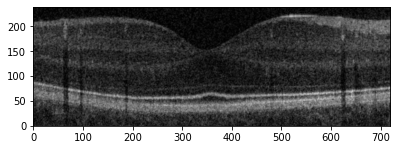

In [58]:
def crop(image, mask):
    h, w = image.shape[:2]  # Handle potential color images
    return image[max(mask[0], 0):min(mask[1], h), max(mask[2], 0):min(mask[3], w)]

def prep_image(imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    filepath = os.path.join(imdir, imname + ".png")
    image = iio.imread(filepath)
    if len(image.shape) == 2:  # Image is grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = np.flipud(crop(image, mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image), 1), round(np.std(image), 1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# This will be a series of the same image with different worm initialisations

def init_population(image, pop_size):
    population = []
    for _ in range(pop_size):
        instance = Instance(image)
        instance.calculate_cost() # calc the cost of all instances in pop
        population.append(instance)
    return population

# create the population of specific size 
# low complex = pop 100; med complex = pop 200-500; high complex = pop 500+
population = init_population(image, 100) # (image, pop_size)

Epoch 1: Best cost = 32393.5935535183
Displaying best individual from Epoch 1


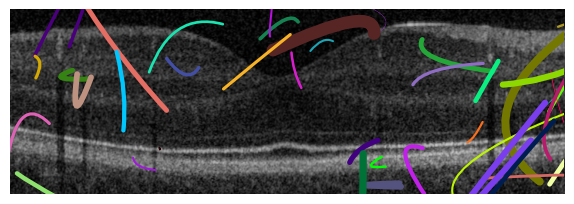

Epoch 2: Best cost = 32602.731017613358
Displaying best individual from Epoch 2


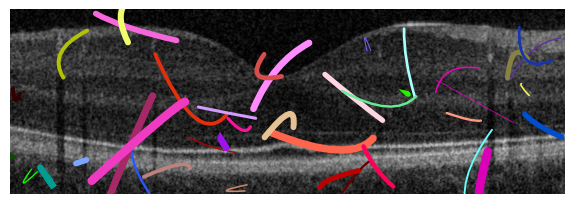

Epoch 3: Best cost = 35631.436335460174
Displaying best individual from Epoch 3


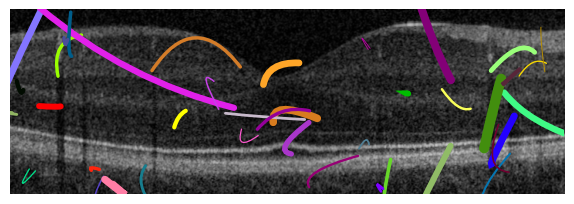

Epoch 4: Best cost = 36626.59110265794
Displaying best individual from Epoch 4


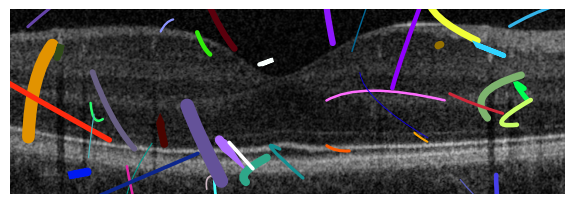

Epoch 5: Best cost = 38442.66586680559
Displaying best individual from Epoch 5


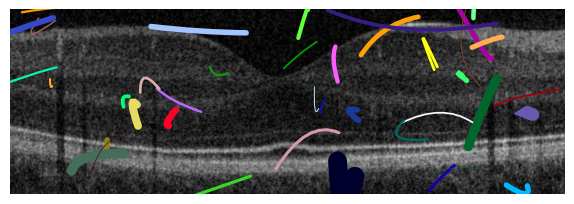

Epoch 6: Best cost = 40829.35426677733
Displaying best individual from Epoch 6


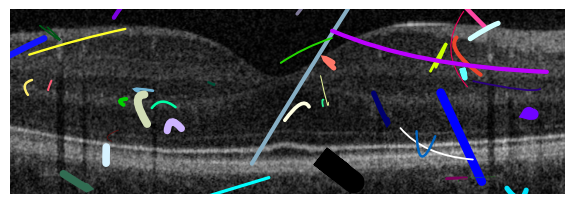

Epoch 7: Best cost = 45238.17237281993
Displaying best individual from Epoch 7


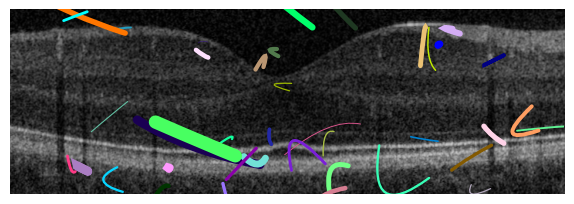

Epoch 8: Best cost = 44455.14276759471
Displaying best individual from Epoch 8


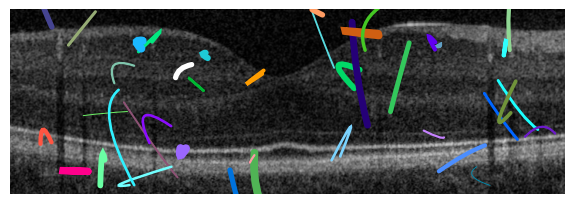

Epoch 9: Best cost = 46938.89183312567
Displaying best individual from Epoch 9


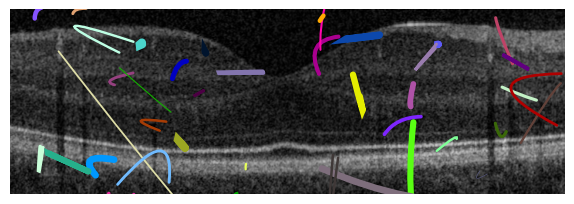

Epoch 10: Best cost = 63061.13742487058
Displaying best individual from Epoch 10


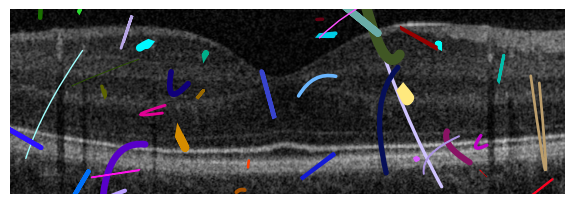

In [142]:
ga = Genetic_Algorithm()
ga.run_genetic_algorithm(population, epochs=10)

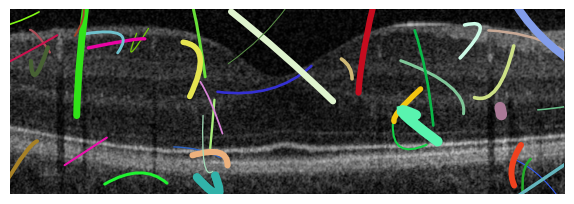

In [161]:
ga = Genetic_Algorithm()
ga.test_mutation(image,epochs=50)